# Image Classification using `sklearn.svm`

In [3]:
from pathlib import Path
import time 
import pickle
import glob 

import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from skimage.io import imread
from skimage.transform import resize
from scipy.sparse import coo_matrix





# Training the SVM by searching for the best parameters

In [4]:
def load_image_files(container_path, dimension=(64, 64)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    #match = {}
    for i, direc in enumerate(folders):
        print("The following folder is being processed: ", direc, str(i))
     #   match[i] = direc[len(container_path):-1]
        for file in direc.iterdir():
            
            img = imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten()) 
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

## Load data

In [ ]:

t0 = time.time()
train_set = load_image_files("../../data/flowers/train/", dimension=(64, 64))

print("Training set with 64 x 64 images is loaded after: ", time.time() - t0)

print()

t0 = time.time()
test_set = load_image_files("../../data/flowers/test/", dimension=(64, 64))
print("Test set with 64 x 64 images is loaded after: ", time.time() - t0)


# load and shuffle the training set 

X_train = train_set.data
y_train = train_set.target
tr_names = train_set.target_names

X_sparse = coo_matrix(X_train)
X_train, _, y_train = shuffle(X_train, X_sparse, y_train, random_state=700)


# load and shuffle the test set
X_test = test_set.data
y_test = test_set.target
t_names = test_set.target_names


# Visualize the result before shuffling
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(X_test[0].reshape((64, 64, 3)))
plt.title(t_names[y_test[0]])
fig.suptitle('Before shuffling', fontsize=16)

fig.add_subplot(122)
plt.imshow(X_test[2].reshape((64, 64, 3)))
plt.title(t_names[y_test[2]])
plt.show()


X_sparse = coo_matrix(X_test)
X_test, _, y_test = shuffle(X_test, X_sparse, y_test, random_state=700)


# Visualize the result after shuffling
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(X_test[0].reshape((64, 64, 3)))
plt.title(t_names[y_test[0]])
fig.suptitle('After shuffling', fontsize=16)


fig.add_subplot(122)
plt.imshow(X_test[2].reshape((64, 64, 3)))
plt.title(t_names[y_test[2]])
plt.show()

print(X_train.shape, y_train.shape)
print(tr_names)
print(X_test.shape, y_test.shape)
print(t_names)

The following folder is being processed:  ../../data/flowers/train/dandelion 0
The following folder is being processed:  ../../data/flowers/train/tulip 1
The following folder is being processed:  ../../data/flowers/train/sunflower 2
The following folder is being processed:  ../../data/flowers/train/rose 3
The following folder is being processed:  ../../data/flowers/train/daisy 4
Training set with 64 x 64 images is loaded after:  60.99750328063965

The following folder is being processed:  ../../data/flowers/test/dandelion 0
The following folder is being processed:  ../../data/flowers/test/tulip 1
The following folder is being processed:  ../../data/flowers/test/sunflower 2
The following folder is being processed:  ../../data/flowers/test/rose 3
The following folder is being processed:  ../../data/flowers/test/daisy 4
Test set with 64 x 64 images is loaded after:  19.184884071350098


## Train data with parameter optimization

In [ ]:
toTrain = False

if toTrain:
    t0 = time.time()
    
    param_grid=[
        {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
        {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}]
    
    svc = svm.SVC()
    clf = GridSearchCV(svc, param_grid)
    clf.fit(X_train, y_train)

    print("Training is done after: ", time.time()-t0)
    
    with open('../models/svm.pkl', 'wb') as fid:
        pickle.dump(clf, fid)
    print("Model saved.")
else:
    with open('../models/svm.pkl', 'rb') as fid:
        clf = pickle.load(fid)
    print("Model loaded.")

### Predict and Report

In [7]:
y_pred = clf.predict(X_test)
print("Predictions are ready to visialize.")

print("Best tuning parameters are:")
print(clf.best_params_)
print()
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_test, y_pred)))



Predictions are ready to visialize.
Best tuning parameters are:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Classification report for - 
GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}]):
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       252
           1       0.76      0.75      0.75       252
           2       0.84      0.86      0.85       252
           3       0.67      0.56      0.61       252
           4       0.74      0.73      0.73       252

    accuracy                           0.74      1260
   macro avg       0.74      0.74      0.74      1260
weighted avg       0.74      0.74      0.74      1260




### Visualize results


<IPython.core.display.Javascript object>


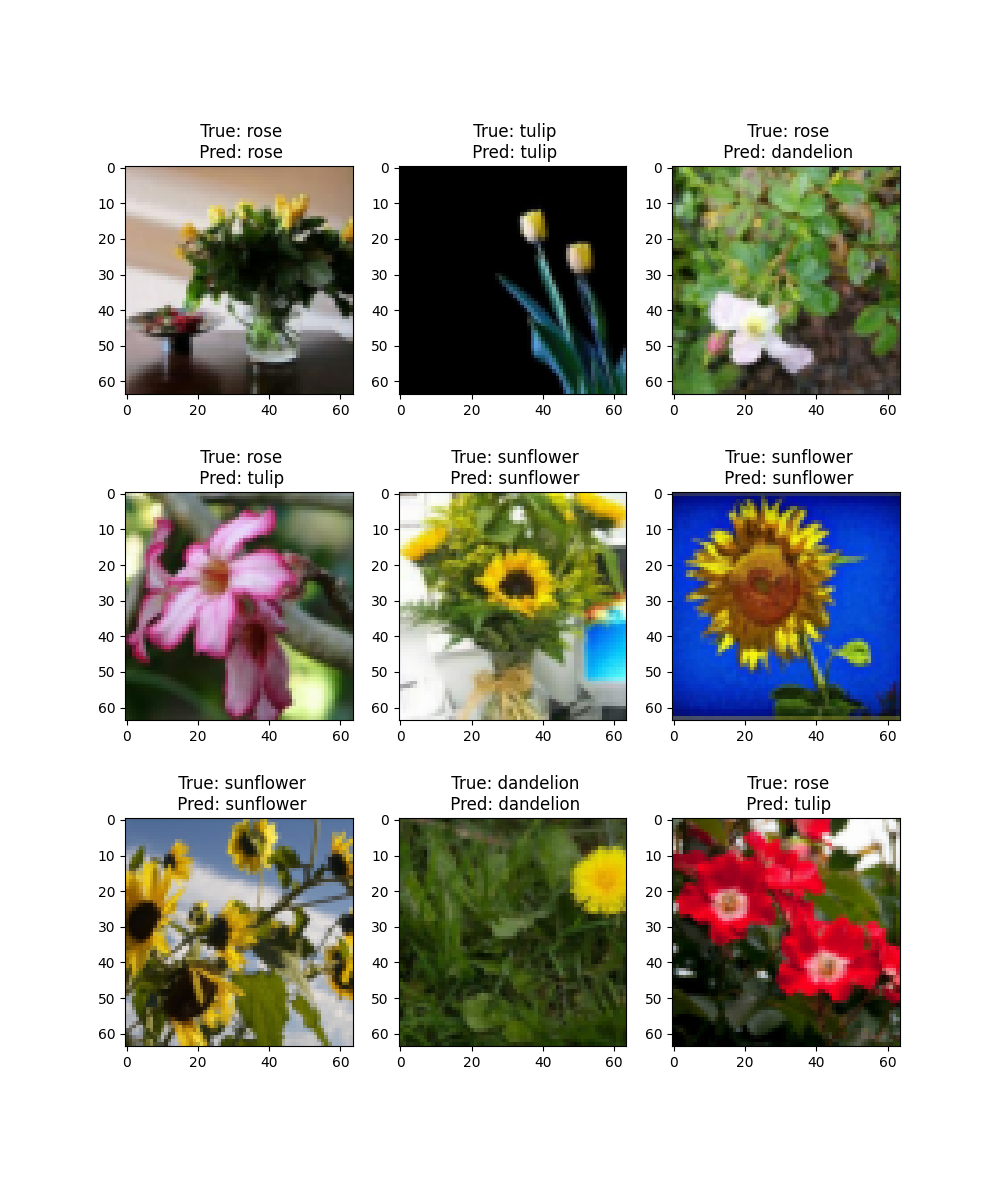

<IPython.core.display.Javascript object>


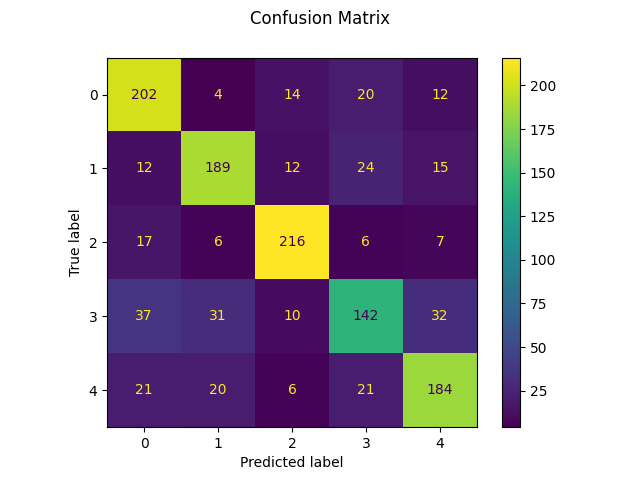

Confusion matrix:
[[202   4  14  20  12]
 [ 12 189  12  24  15]
 [ 17   6 216   6   7]
 [ 37  31  10 142  32]
 [ 21  20   6  21 184]]


In [9]:
fig = plt.figure(figsize=(10, 12))
for i in range(9):
    fig.add_subplot(3, 3, i+1)    
    plt.imshow((X_test[1000 + i].reshape((64, 64, 3))))
    plt.title(" True: " + t_names[y_test[1000 + i]] + "\n Pred: " + str(t_names[y_pred[1000 + i]]))
plt.show()

disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)